In [5]:
# Import các thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score

In [6]:
# Kết nối tới drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Đọc file
train = pd.read_csv("/content/drive/MyDrive/final_unbalanced.csv",low_memory=False)

In [8]:
train.shape

(1211912, 72)

In [9]:
df = train
df

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,690035,172.31.64.38-95.215.62.54-3389-52201-6,95.215.62.54,52201,172.31.64.38,3389,6,20/02/2018 12:26:05,4544883,12,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,2702781,172.31.0.2-172.31.64.96-53-57165-17,172.31.64.96,57165,172.31.0.2,53,17,20/02/2018 12:49:58,353,1,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,6540559,172.31.66.103-23.36.34.146-51340-443-6,172.31.66.103,51340,23.36.34.146,443,6,20/02/2018 10:31:00,5206057,6,...,20,136669.0,0.0,136669.0,136669.0,5069365.0,0.0,5069365.0,5069365.0,Benign
3,138035,151.101.20.129-192.168.10.51-80-60389-6,192.168.10.51,60389,151.101.20.129,80,6,03/07/2017 08:16:07 PM,5688954,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,7653122,172.31.65.87-185.129.148.159-3389-20750-6,172.31.65.87,3389,185.129.148.159,20750,6,20/02/2018 05:17:04,82717004,2,...,20,0.0,0.0,0.0,0.0,82717010.0,0.0,82717010.0,82717010.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211907,1170714,172.31.0.2-172.31.66.100-53-65526-17,172.31.66.100,65526,172.31.0.2,53,17,20/02/2018 10:43:12,1771,1,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1211908,7871939,139.60.161.214-172.31.67.8-31903-3389-6,172.31.67.8,3389,139.60.161.214,31903,6,20/02/2018 05:16:05,88514671,2,...,20,0.0,0.0,0.0,0.0,88514670.0,0.0,88514670.0,88514670.0,Benign
1211909,5218102,172.31.68.10-117.4.80.56-3389-11737-6,117.4.80.56,11737,172.31.68.10,3389,6,20/02/2018 08:56:56,2531695,8,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1211910,4160149,172.31.0.2-172.31.66.75-53-64765-17,172.31.66.75,64765,172.31.0.2,53,17,20/02/2018 03:20:55,131277,2,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [10]:
# Label Encoding
from sklearn import preprocessing

for f in train.columns:
    if train[f].dtype == 'object':
        label = preprocessing.LabelEncoder()
        label.fit(list(train[f].values))
        train[f] = label.transform(list(train[f].values))

In [11]:
# Thay thế các giá trị NaN thành -999
train.fillna((-999), inplace=True)

In [12]:
# Chuyển tất cả kiểu dữ liệu của train sang kiểu float
train = train.astype(float)

In [13]:
train

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,690035.0,480872.0,21050.0,52201.0,4656.0,3389.0,6.0,54164.0,4544883.0,12.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2702781.0,193349.0,5011.0,57165.0,4604.0,53.0,17.0,55597.0,353.0,1.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6540559.0,625965.0,5119.0,51340.0,10969.0,443.0,6.0,47259.0,5206057.0,6.0,...,20.0,136669.0,0.0,136669.0,136669.0,5069365.0,0.0,5069365.0,5069365.0,0.0
3,138035.0,20507.0,8627.0,60389.0,3664.0,80.0,6.0,6795.0,5688954.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7653122.0,611718.0,5105.0,3389.0,6274.0,20750.0,6.0,37337.0,82717004.0,2.0,...,20.0,0.0,0.0,0.0,0.0,82717010.0,0.0,82717010.0,82717010.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211907,1170714.0,248366.0,5116.0,65526.0,4604.0,53.0,17.0,47991.0,1771.0,1.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1211908,7871939.0,7703.0,5298.0,3389.0,3190.0,31903.0,6.0,37278.0,88514671.0,2.0,...,20.0,0.0,0.0,0.0,0.0,88514670.0,0.0,88514670.0,88514670.0,0.0
1211909,5218102.0,820923.0,2244.0,11737.0,5018.0,3389.0,6.0,41615.0,2531695.0,8.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1211910,4160149.0,307435.0,5190.0,64765.0,4604.0,53.0,17.0,30368.0,131277.0,2.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Chia tập dữ liệu thành 2 phần Features và Target
Y = train['Label']
X = train.drop("Label",axis=1)

In [15]:
print(train.shape)
print(X.shape)
print(Y.shape)

(1211912, 72)
(1211912, 71)
(1211912,)


In [16]:
# Chia tập dữ liệu thành 2 phần train - test (8-2)
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(969529, 71)
(969529,)
(242383, 71)
(242383,)


In [18]:
from sklearn.model_selection import GridSearchCV

# Tạo một lưới các giá trị tham số cần thử
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Khởi tạo mô hình Decision Tree
model = DecisionTreeClassifier(random_state=0)

# Sử dụng Grid Search để tìm tham số tốt nhất
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}


In [19]:
# Lấy mô hình đã tối ưu
best_model = grid_search.best_estimator_

# Huấn luyện mô hình với các tham số tối ưu trên toàn bộ tập huấn luyện
best_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test)

In [20]:
print(best_model)

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=0)


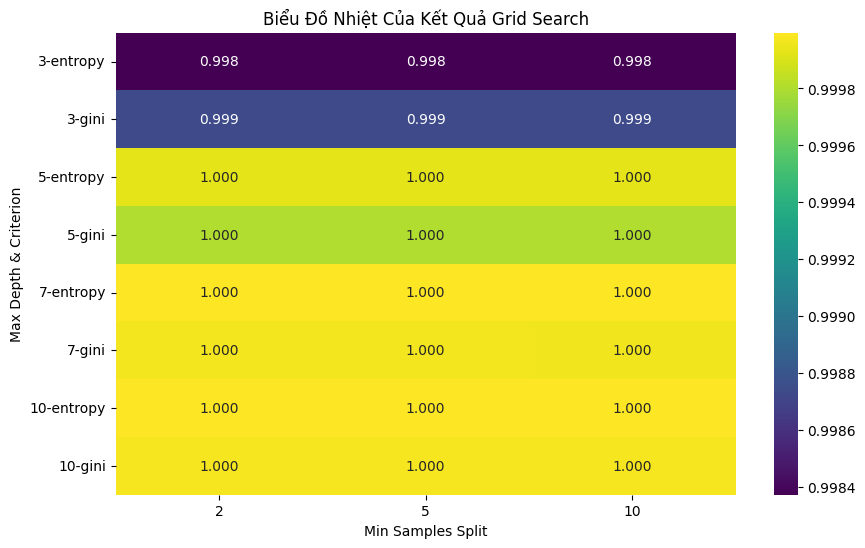

In [21]:
import seaborn as sns
# Chuyển kết quả tìm kiếm lưới thành DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Chọn chỉ các cột quan trọng
important_columns = ['mean_test_score', 'param_max_depth', 'param_min_samples_split', 'param_criterion']

# Lọc kết quả với các cột đã chọn
filtered_results = results[important_columns]

# Tạo pivot table để dễ dàng vẽ biểu đồ
pivot_table = filtered_results.pivot_table(
    values='mean_test_score',
    index=['param_max_depth', 'param_criterion'],
    columns='param_min_samples_split'
)

# Trực quan hóa dữ liệu dưới dạng biểu đồ nhiệt
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title('Biểu Đồ Nhiệt Của Kết Quả Grid Search')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth & Criterion')
plt.show()

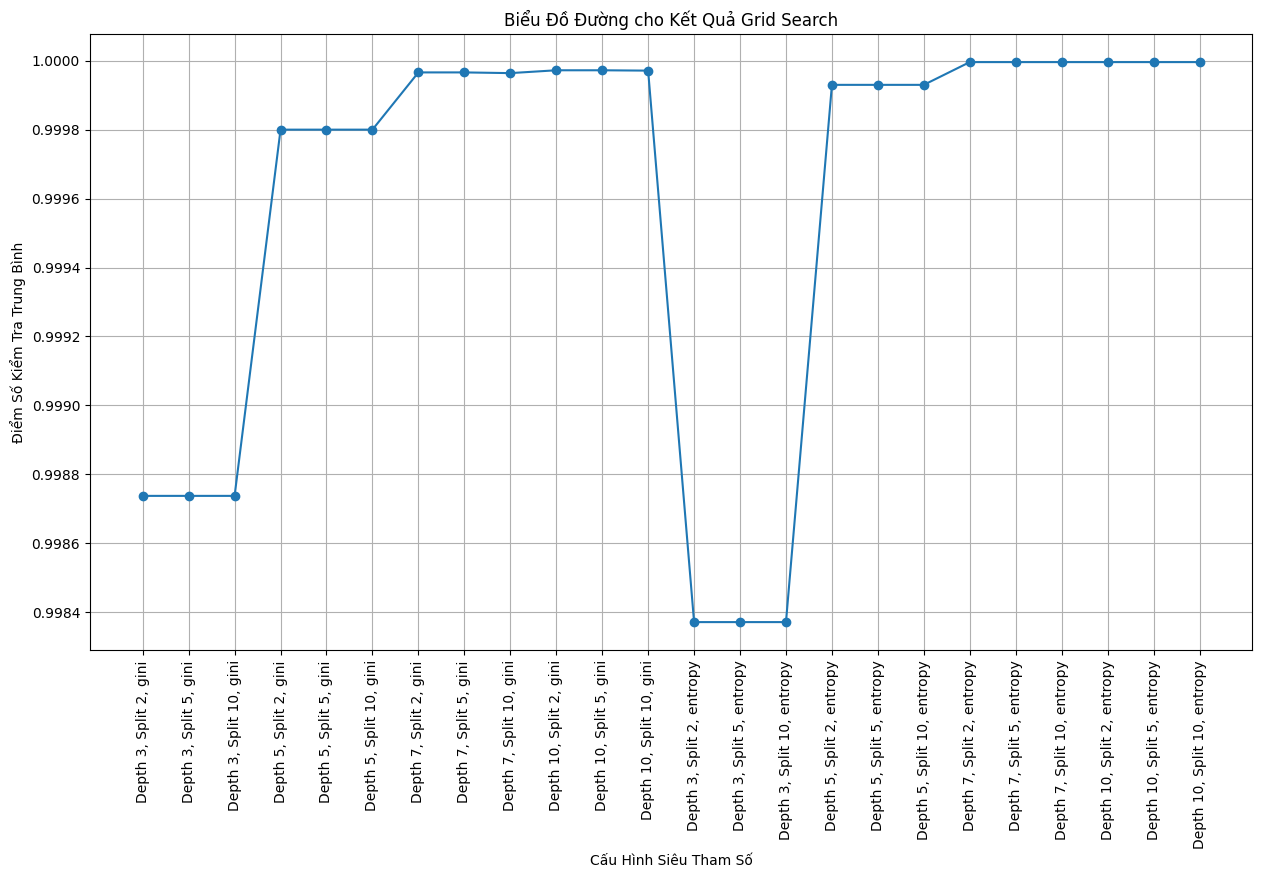

In [22]:
# Chuyển đổi kết quả tìm kiếm lưới thành DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Thêm cột nhận dạng cho mỗi cấu hình siêu tham số
results['case'] = results.apply(lambda row: f"Depth {row['param_max_depth']}, Split {row['param_min_samples_split']}, {row['param_criterion']}", axis=1)

# Vẽ biểu đồ
plt.figure(figsize=(15, 8))
plt.plot(results['case'], results['mean_test_score'], marker='o')

# Đặt các tick trên trục x
plt.xticks(rotation=90)  # Xoay các tick để dễ đọc
plt.title('Biểu Đồ Đường cho Kết Quả Grid Search')
plt.xlabel('Cấu Hình Siêu Tham Số')
plt.ylabel('Điểm Số Kiểm Tra Trung Bình')
plt.grid(True)
plt.show()

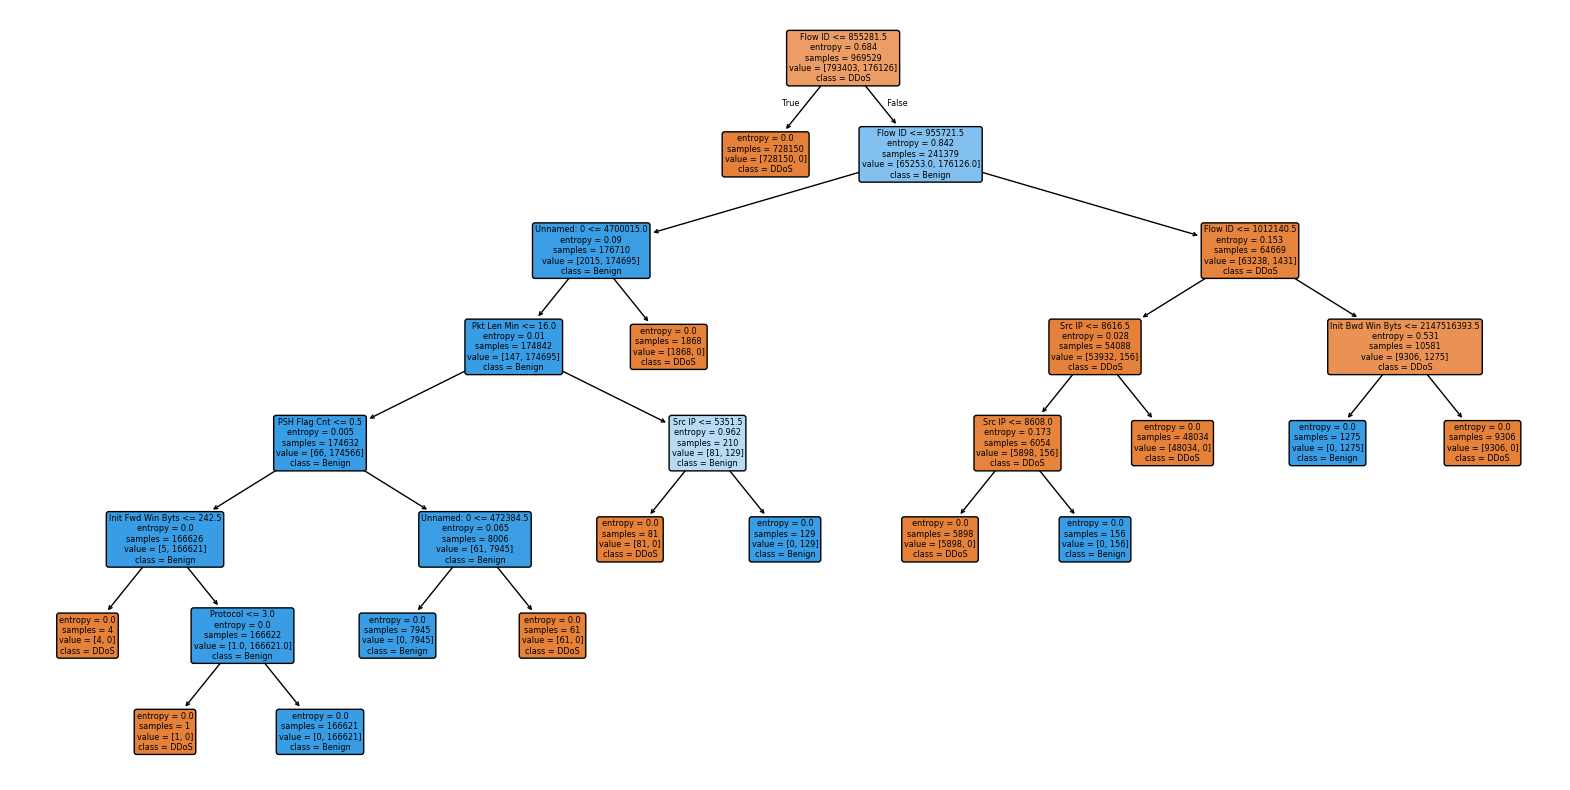

In [23]:
# Vẽ cây quyết định
from sklearn import tree
plt.figure(figsize=(20,10))  # Thiết lập kích thước hình ảnh
tree.plot_tree(best_model,
               filled=True,
               rounded=True,
               class_names=["DDoS", "Benign"],
               feature_names=X.columns)  # Sử dụng tên các đặc trưng trong dữ liệu
plt.show()

In [24]:
# Tính toán độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("accuracy:",accuracy)

accuracy: 0.999995874298115


In [25]:
# Tính toán điểm F1
f1score=f1_score(y_test, y_pred)
print("f1-acore:",f1score)

f1-acore: 0.9999886217529328


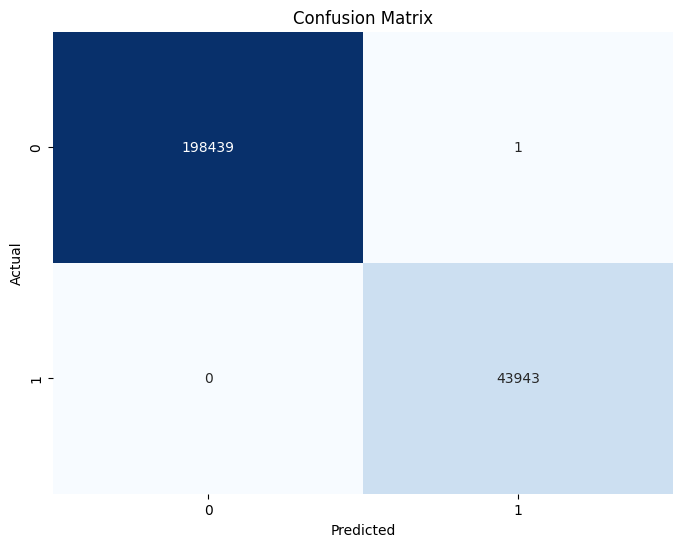

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Tính ma trận nhầm lẫn
confusion = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:
pr=precision_score(y_test,y_pred)
print("Precision:",pr)

rs=recall_score(y_test,y_pred)
print("Recall_score:",rs)

# Tính toán những mẫu mà mô hình dự đoán sai so với nhãn thực tế
misclassified_samples = X_test[y_test != y_pred]
mc=misclassified_samples.shape[0]
print("Misclassified :",mc)

Precision: 0.9999772437647916
Recall_score: 1.0
Misclassified : 1


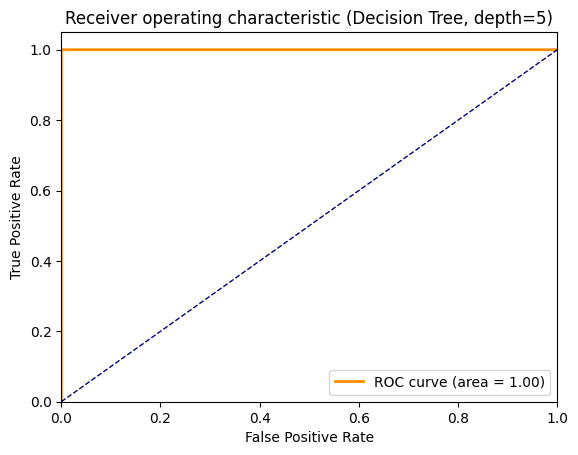

In [28]:
# Vẽ đường cong ROC (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (Decision Tree, depth=5)')
plt.legend(loc="lower right")
plt.show()